<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_11%5D_Ai_made_New_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11-14.프로젝트 : CIFAR-10 이미지 생성하기

- 기존 LMS와 달라진 내용

(1) 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.

(2) 미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.

(3) 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [ ]:
# 라이브러리 환경 구축
import os, sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env2 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env2', my_path)
sys.path.insert(0, my_path)

In [ ]:
# Pillow 라이브러리 업데이트 
# LMS와 일치하게 버젼을 8.3.2로 맞춘다
# 경로를 설정하여 영구적으로 해당 버젼을 사용할 수 있게 환경을 조성하였다.
!pip install --target=$my_path Pillow==8.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 7.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires pillow!=8.3.*,>=5.3.0, but you have pillow 8.3.2 which is incompatible.


In [ ]:
import os
import glob
import time

from tensorflow.keras.layers import Dropout
import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


# STEP1 작업환경 구성하기

- colab에 미리 generated_samples / training_checkpoints / training_history 만들어두었다.

# STEP2 데이터셋 구성

- CIFAR-10 데이터셋은 keras안에 데이터셋이 포함되어있기때문에 로드하여 사용가능하다

- 이미지 크기 : 32 * 32 * 3
- 데이터셋 크기 : train(50000장), test(10000장)

In [ ]:
# 데이터 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape
# 이번에는 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없습니다.
# y_train, y_test에 해당하는 데이터를 쓰지 않는 거죠
# _(언더 스코어)를 사용하여 해당 데이터는 무시할 수 있다.

(50000, 32, 32, 3)

In [ ]:
# 데이터 정규화 - 0중심
# 이번 과정에서는 데이터를 [-1, 1]로 정규화 시키기 때문에 255가 아닌 127.5를 빼주고 다시 127.5로 나눈다.

train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
print("shape:", train_x.shape)

# 총 50000장의 train데이터와 32*32*3 사이즈의 이미지가 있음을 알 수 있다.
# 이미 RGB채널이 추가되었기때문에 채널 수 추가는 하지 않는다.

max pixel: 1.0
min pixel: -1.0
shape: (50000, 32, 32, 3)


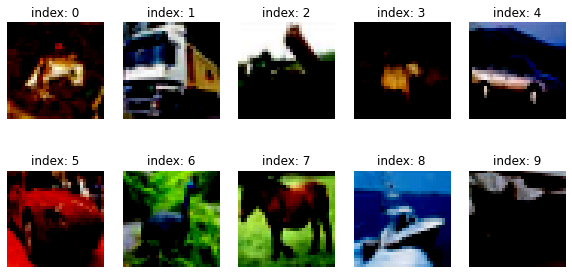

In [ ]:
# 학습 데이터 여러 개 이미지 출려해보기
plt.figure(figsize=(10, 5)) # 이미지의 전체 프레임

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]).reshape(32, 32, 3))
    plt.title(f'index: {i}') # 이미지에 제목
    plt.axis('off') # 불필요한 축을 지워서 깔끔하게 출력
plt.show() 

# 상당히 어두운 색채를 가진 이미지가 출력이 되었다.
# 오류 메시지를 내용을보면 정규화를 해준 과정에서 색 출력이 문제가 생긴것으로 보인다.

In [ ]:
# 정규화된 데이터를 (0~255) 의 RBG 값을 가진 데이터로 변환하여 시각화하기 위해 de_nomalize() 함수를 구현한다.
def de_normalize(train):
    return (127.5 * train) + 127.5

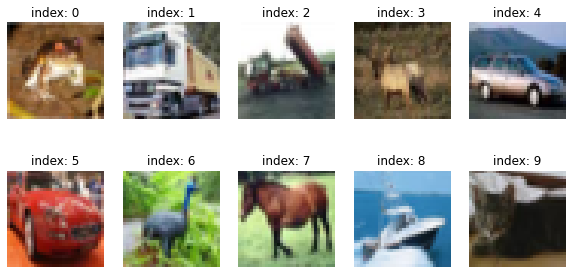

In [ ]:
# 학습 데이터 여러 개 이미지 출력해보기 - RGB 변환
plt.figure(figsize=(10, 5)) # 이미지의 전체 프레임

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(de_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3))
    plt.title(f'index: {i}') # 이미지에 제목
    plt.axis('off') # 불필요한 축을 지워서 깔끔하게 출력
plt.show() 

In [ ]:
# 학습 준비하기

BUFFER_SIZE = 50000 # 전체 데이터를 섞기 위해 50000으로 설정
BATCH_SIZE = 256 # 한번에 학습할 데이터 크기

In [ ]:
# 미니배치 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [ ]:
# DCGAN(Deep Convolutional GAN) 구현

def make_generator_model():
  # Start
  model = tf.keras.Sequential()

  # First: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization()) # BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 시켜준다.
  model.add(layers.LeakyReLU()) # LeakyReLU 활성화 함수 적용 

  # Second: Reshape layer
  model.add(layers.Reshape((8,8,256)))

  # Third: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding = 'same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU()) 

  # Fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding = 'same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU()) 

  # Fifth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2),  padding='same', use_bias=False, \
                                   activation = 'tanh'))
  # 마지막 층에서 tanh 활성화함수를 사용한 이유는 [-1, 1]이내의 값으로 픽셀 값을 정규화 시켰던 데이터셋과 동일하게 하기 위함
  
  return model

  # Conv2DTranspose : 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
  # 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다. 
  # 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일

In [ ]:
# DCGAN(Deep Convolutional GAN) 구현

def make_generator_model():
  # Start
  model = tf.keras.Sequential()

  # First: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(200,)))
  model.add(layers.BatchNormalization()) # BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 시켜준다.
  model.add(layers.LeakyReLU()) # LeakyReLU 활성화 함수 적용 

  # Second: Reshape layer
  model.add(layers.Reshape((8,8,256)))

  # Third: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding = 'same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU()) 

  # Fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding = 'same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU()) 

  # Fifth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2),  padding='same', use_bias=False, \
                                   activation = 'tanh'))
  # 마지막 층에서 tanh 활성화함수를 사용한 이유는 [-1, 1]이내의 값으로 픽셀 값을 정규화 시켰던 데이터셋과 동일하게 하기 위함
  
  return model

  # Conv2DTranspose : 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
  # 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다. 
  # 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일

In [ ]:
# generator summary를 출력

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             3276800   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
# 지금은 학습하는 중이 아니기에 training=False이다.
generated_image.shape

# TensorShape([1, 32, 32, 3])
# 1 : batch_size = 1, (32, 32, 3) : 이미지

TensorShape([1, 32, 32, 3])

In [ ]:
# 랜덤 노이즈 벡터 생성 (추가)
noise = tf.random.normal([1, 200])

generated_image = generator(noise, training=False)
# 지금은 학습하는 중이 아니기에 training=False이다.
generated_image.shape

# TensorShape([1, 32, 32, 3])
# 1 : batch_size = 1, (32, 32, 3) : 이미지

TensorShape([1, 32, 32, 3])

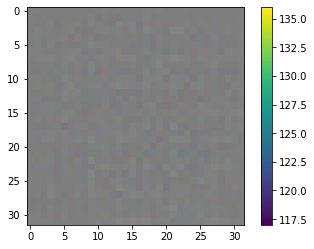

In [ ]:
# 랜덤 이미지 출력
plt.imshow(de_normalize(generated_image[0].numpy()).astype(np.int32))
plt.colorbar()
plt.show()

# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

# STEP 4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성

- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten()) # 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

  # 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다.
  # 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할

In [ ]:
# discriminator summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
# 가짜 이미지 판별자
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00081689]], dtype=float32)>

# STEP 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다

1. 손실함수(loss function)
- GAN은 손실함수로 Cross Entropy를 사용
- 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, binary cross entropy를 사용할 것입니다.

- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것

- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

- 결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.

- 판별자 모델의 마지막에는 활성화 함수가 없었다. 즉 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다.

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)

- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [ ]:
# cross_entropy 사용
# from_logits=True : BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# generator_loss 구현

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# generator_loss는 fake_output이 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
# 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [ ]:
# discriminator_loss 구현

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  # real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다.
  # real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교

In [ ]:
# discriminator accuracy 구현
# accuracy가 1에 가깝다면 좋은걸까?
# 답은 그렇지 않다. 왜냐하면 fake output이 real output과 차이가 많이나서
# 판별자가 매우 쉽게 구분하고 있다는 것을 의미한다.
# real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
# fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
# 최적화 함수(optimizer)
# 이번 프로젝트에서는 Adam을 사용한다.
# Adam : Momentum과 AdaGrad를 섞은 기법 /  습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 방법

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 최적화 함수(optimizer)
# 이번 프로젝트에서는 Adam을 사용한다.
# Adam : Momentum과 AdaGrad를 섞은 기법 /  습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 방법
# 판별자에는 SGD optimizer를 사용하였다

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.SGD(1e-4)

In [ ]:
noise_dim = 100 # 차원
num_examples_to_generate = 16 # 샘플 수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 생성할 샘플은 매번 같은 노이즈로 생성해야 
# 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
seed.shape

TensorShape([16, 100])

In [ ]:
noise_dim = 200 # 차원
num_examples_to_generate = 16 # 샘플 수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 생성할 샘플은 매번 같은 노이즈로 생성해야 
# 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
seed.shape

TensorShape([16, 200])

# STEP 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

# Tensorflow decorator란?
[Tensorflow decorator](https://www.tensorflow.org/api_docs/python/tf/function)

- 역활 정의 : tf.function : Compiles a function into a callable TensorFlow graph (함수를 호출 가능한 TensorFlow 그래프로 컴파일합니다)

- @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환


In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음

(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기

(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성

(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력

(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산

(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산

(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산

(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신

(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

In [ ]:
# 학습 현황을 확인 할 수 있는 함수 구현

def generate_and_save_images(model, epoch, it, sample_seeds):

  predictions = model(sample_seeds, training = False)

  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(de_normalize(predictions[i, :, :, :].numpy()).astype(np.int32))
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/Aiffel/EX/EX11.Image/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

  plt.show()

In [ ]:
# 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 
# accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')   
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Aiffel/EX/EX11.Image/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# checkpoint만들기

checkpoint_dir = '/content/drive/MyDrive/Aiffel/EX/EX11.Image/training_checkpoints'

checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [ ]:
# train 함수 구현
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 30
EPOCHS = 300

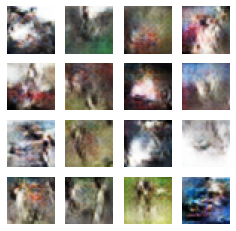

Time for training : 5715 sec


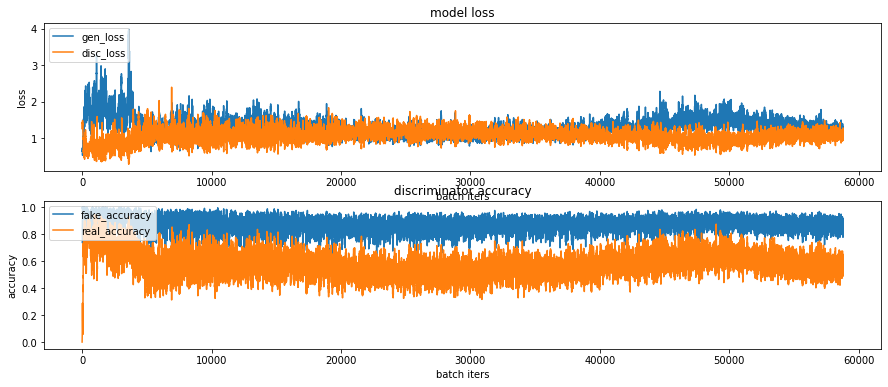

CPU times: user 1h 22min 45s, sys: 2min 3s, total: 1h 24min 49s
Wall time: 1h 35min 18s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/EX/EX11.Image/cifar-10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/EX/EX11.Image/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
!ls -al /content/drive/MyDrive/Aiffel/EX/EX11.Image/cifar-10_dcgan.gif

-rw------- 1 root root 5674334 Aug 30 12:28 /content/drive/MyDrive/Aiffel/EX/EX11.Image/cifar-10_dcgan.gif


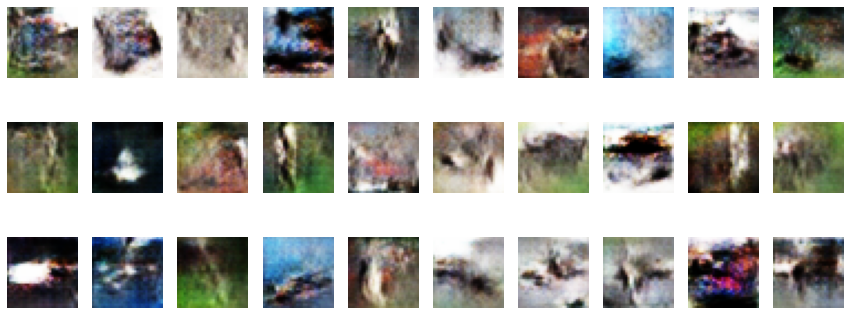

In [ ]:
# 체크포인트 활용
checkpoint_dir = '/content/drive/MyDrive/Aiffel/EX/EX11.Image/training_checkpoints'
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

for i in range(30):
    plt.subplot(3, 10, i+1)
    #noise = tf.random.normal([1, 100])
    noise = tf.random.normal([1, 200])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다

epoch 300.GIF

<img src = "https://drive.google.com/uc?id=14zNhFxPZxIHbsmrozIAYDoXgOVCEpRa6" height = 300 width = 300>

epoch 300 체크포인트 결과 확인

<img src = "https://drive.google.com/uc?id=1tiFTVW85oK7MSvrwvDz0rQlN34vsYRQw" height = 400 width = 600>

epoch 300(noise [1, 200]).GiF

<img src = "https://drive.google.com/uc?id=1eYqwkl9ZsX8NlMr1i1r-Hz8bHSOuXUgC" height = 300 width = 300>

epoch 300(noise [1, 200]) 체크포인트 결과 확인

<img src = "https://drive.google.com/uc?id=11yTV2YaVdWRXZ7q-0L5tJvS8nWETw6d1" height = 400 width = 600>


epoch 1000.GiF

<img src = "https://drive.google.com/uc?id=1fKVcLUNfqSTrwR1u31YaCRerZUxsoK5a" height = 300 width = 300>

epoch 1000 체크포인트 결과 확인

<img src = "https://drive.google.com/uc?id=1D0BEmJBMoaV-TATxYAGblXiZEOVHZuAa" height = 400 width = 600>








epoch 300과 1000을 비교해보았을때 1000에서 좀 더 물체의 형상을 구채적으로 잡아가고있다. 더 많은 epoch를 사용해보고 싶었으나 여건이 부족하여 1000에서 종료하였다.

epoch 300에서 noise를 [1, 200]으로 확장시켜 학습을 시켜보았다. noise의 확장은 학습 결과에 유의미한 영향을 주지 못하는 것으로 들어났다.


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 첫 번째 시도에서 학습데이터의 이미지가 기존 cifar-10 색감이 어둡게 나오던 현상이 있었습니다. 이 문제를 해결하기 위해 (0~255) 의 RBG 값을 가진 데이터로 변환하여 시각화하기 위해 de_nomalize() 함수를 작성하고 사용하여 정상적인 색감으로 출력할 수 있었습니다.

 (2) fake accuracy 0.5로 수렴할 수 없어 너무 힘들었습니다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) DCGAN 모델은 어떻게해야 개선할 수 있을까?
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks#authors) 여기서 나온 부분을 몇 가지 활용을 해 보았다. Dropout을 0.5로 적용해보고 optimizer를 생성자에 SGD도 넣어보았다
그러나 좋은 결과는 출력되지 않았다.

참조

(1) [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks#authors)
